In [1]:
import os

os.chdir('/Users/edwardchiu/Desktop/projects/baha-anime-analysis')
os.getcwd()

'/Users/edwardchiu/Desktop/projects/baha-anime-analysis'

In [2]:
import jieba
import jieba.analyse
from wordcloud import WordCloud
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.options import Options
from collections import Counter

In [3]:
def episode_comments(link):
    # Set up headless mode
    options = Options()
    options.add_argument('--headless')  # Run Chrome in headless mode
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    # Set up Selenium with the WebDriver
    driver = webdriver.Chrome(options=options)  # or use webdriver.Firefox() if you're using Firefox

    # Open the target URL
    driver.get(link)
    time.sleep(np.random.uniform(0.5, 1))

    # Danmu scroll
    scroll_item = driver.find_element(By.CLASS_NAME, 'danmu-scroll')

    # Scroll until all items are loaded
    previous_height = 0
    while True:
        # Scroll down the element
        driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", scroll_item)
        time.sleep(np.random.uniform(0.5, 1))  # Wait for items to load

        # Get the new scroll height after scrolling
        new_height = scroll_item.get_attribute('scrollHeight')

        # Break the loop if scrolling has reached the bottom (no new items loaded)
        if new_height == previous_height:
            break
        previous_height = new_height

    # Get danmu string list
    scroll_item = BeautifulSoup(scroll_item.get_attribute('innerHTML'), 'html.parser')
    danmu_list = scroll_item.select('.sub-list-li > div > .sub_content > span')
    danmus = [danmu.text.strip() for danmu in danmu_list]

    # Find and click "Load more" buttons to expand hidden comments, if they exist
    while True:
        try:
            # Locate the "Load more" button or similar to load hidden comments
            load_more_button = driver.find_element(By.CLASS_NAME, 'c-more-msg')
            ActionChains(driver).move_to_element(load_more_button).click(load_more_button).perform()

            # Wait for the content to load after clicking
            time.sleep(np.random.uniform(0.5, 1))
        except:
            # Exit loop if there is no more button to click
            break

    # Comment string list
    comment_item = driver.find_element(By.CLASS_NAME, 'webview_commendlist')
    comment_item = BeautifulSoup(comment_item.get_attribute('innerHTML'), 'html.parser')

    comments = comment_item.select('.reply-content > .reply-content__cont > p')
    comments = [c.text.strip() for c in comments]

    # Close the WebDriver session
    driver.quit()

    # Print or process the episode_dict as needed
    # print(episode_dict)
    return comments, danmus

In [21]:
url = 'https://ani.gamer.com.tw/animeVideo.php?sn=37868'
comments, danmus = episode_comments(url)

In [22]:
# Paths to your files
dict_file = './word-cloud/dict.txt'
stopwords_file = './word-cloud/stopwords.txt'
font_path = './word-cloud/CactusClassicalSerif-Regular.ttf'
mask_image_path = './word-cloud/comment.png'

# Set Jieba dictionary and stopwords
jieba.set_dictionary(dict_file)
jieba.analyse.set_stop_words(stopwords_file)

In [96]:
text = ' '.join(danmus)
tags = jieba.analyse.extract_tags(text, topK=25)
tags

['...',
 '賽車',
 '無聊',
 'AI',
 '感覺',
 '速度感',
 '主播',
 'F1',
 '比較',
 '....',
 '車手',
 '朝聖',
 '1.25',
 '這種',
 '講話',
 '播報員',
 '斯拉',
 '這部',
 'BGM',
 '不會',
 '一樣',
 '倍速',
 '這麼',
 '1.5',
 '畫面']

In [27]:
# Create the mask from the image
mask = np.array(Image.open(mask_image_path))

{'1.25': 11, '這部': 10, '賽車': 34, '這麼': 9, '朝聖': 12, '...': 39, '1.5': 9, '斯拉': 11, 'BGM': 10, '不會': 10, '這種': 11, '一樣': 10, 'F1': 14, '....': 13, '畫面': 9, '講話': 11, 'AI': 18, '感覺': 16, '車手': 13, '速度感': 16, '比較': 14, '播報員': 11, '主播': 15, '無聊': 19, '倍速': 9}


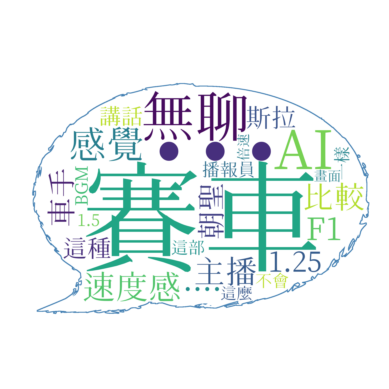

In [28]:
seg_list = jieba.lcut(text, cut_all=False)
dictionary = Counter(seg_list)

freq = {}
for ele in dictionary:
    if ele in tags:
        freq[ele] = dictionary[ele]
print(freq)  # 計算出現的次數

wordcloud = WordCloud(
    background_color="white",
    mask=mask,
    contour_width=3,
    contour_color='steelblue',
    font_path=font_path
).generate_from_frequencies(freq)

plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [107]:
import pandas as pd
import gspread
from google.oauth2.service_account import Credentials
from gspread_dataframe import set_with_dataframe
import modules.settings as settings

In [108]:
# Authenticate with Google
creds = Credentials.from_service_account_file(settings.service_account_file, scopes=settings.scope)
client = gspread.authorize(creds)

In [109]:
df = pd.DataFrame(list(freq.items()), columns=['tag', 'count'])
sheetname = settings.sheetname
spreadsheet = client.open(sheetname)

In [110]:
worksheet = spreadsheet.worksheet('Word Cloud')
set_with_dataframe(worksheet, df)

In [116]:
def convert_to_utf8(val):
    if isinstance(val, str):
        return val.encode('utf-8', errors='ignore').decode('utf-8')
    return str(val)

In [118]:
df = df.map(convert_to_utf8)

In [131]:
header = [df.columns.tolist()]
values = df.values.tolist()
values

[['1.25', '11'],
 ['這部', '10'],
 ['賽車', '34'],
 ['這麼', '9'],
 ['朝聖', '12'],
 ['...', '39'],
 ['1.5', '9'],
 ['斯拉', '11'],
 ['BGM', '10'],
 ['不會', '10'],
 ['這種', '11'],
 ['一樣', '10'],
 ['F1', '14'],
 ['....', '13'],
 ['畫面', '9'],
 ['講話', '11'],
 ['AI', '18'],
 ['感覺', '16'],
 ['車手', '13'],
 ['速度感', '16'],
 ['比較', '14'],
 ['播報員', '11'],
 ['主播', '15'],
 ['無聊', '19'],
 ['倍速', '9']]

In [132]:
header + values

[['tag', 'count'],
 ['1.25', '11'],
 ['這部', '10'],
 ['賽車', '34'],
 ['這麼', '9'],
 ['朝聖', '12'],
 ['...', '39'],
 ['1.5', '9'],
 ['斯拉', '11'],
 ['BGM', '10'],
 ['不會', '10'],
 ['這種', '11'],
 ['一樣', '10'],
 ['F1', '14'],
 ['....', '13'],
 ['畫面', '9'],
 ['講話', '11'],
 ['AI', '18'],
 ['感覺', '16'],
 ['車手', '13'],
 ['速度感', '16'],
 ['比較', '14'],
 ['播報員', '11'],
 ['主播', '15'],
 ['無聊', '19'],
 ['倍速', '9']]

In [135]:
worksheet.update(range_name='A:B', values=header + values, raw=False)

{'spreadsheetId': '1F94CV-TTa628TumABt3DOF_beqJxQTJ-Mjp1nHkWQDE',
 'updatedRange': "'Word Cloud'!A1:B26",
 'updatedRows': 26,
 'updatedColumns': 2,
 'updatedCells': 52}

In [134]:
worksheet.batch_clear(['A:B'])

{'spreadsheetId': '1F94CV-TTa628TumABt3DOF_beqJxQTJ-Mjp1nHkWQDE',
 'clearedRanges': ["'Word Cloud'!A1:B1000"]}

In [29]:
# Save the word cloud as a PNG file
output_image_path = './word-cloud/danmu_wordcloud.png'  # File path to save the image
wordcloud.to_file(output_image_path)
print(f"Word cloud image saved to {output_image_path}")

Word cloud image saved to ./word-cloud/danmu_wordcloud.png


In [30]:
from fastapi.responses import FileResponse

In [31]:
FileResponse(output_image_path, media_type='image/png', filename='wordcloud.png')

In [32]:
import requests

In [158]:
url = 'https://5d52-118-168-232-22.ngrok-free.app/'
payload = {
    'anime_name': '咒術迴戰',
    'episode_name': '[14]'
}
req = requests.post(url + '/word_freq', json=payload)
# req = requests.get(url)

In [157]:
req.json()

{'detail': "'anime_anme'"}

In [148]:
df = pd.read_csv('data/all_episode.csv')

In [151]:
df.loc[(df['anime_name'] == '咒術迴戰') & (df['episode_name'] == '[14]'), 'episode_link'].iloc[0]

'https://ani.gamer.com.tw/animeVideo.php?sn=20347'

In [138]:
req.json()

{'detail': 'Out of range float values are not JSON compliant: nan'}

In [94]:
url + '/' + 'comment_cloud.jpg'

'https://e1ec-118-168-232-22.ngrok-free.app/comment_cloud.jpg'

In [78]:
file_path = req.json()['comment']['path'][2:]
req2 = requests.get(url + f'/files/{file_path}')

In [79]:
file_path

'word-cloud/comment_wordcloud.png'